### Importações necessárias

In [1]:
import unidecode
import re
import string
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

from gensim.models import Word2Vec

%matplotlib inline

#### Análise de dataset

In [2]:
df = pd.read_csv("Dataset_final.csv")

df.head()

,texts,labels
0,Como cometer suicídio sem dx a mãe triste,0
1,Estou nova demais p cometer esse suicídio,0
2,"""Nunca dirijo meu carro por cima de uma ponte ...",0
3,Nem imagino como seria minha vida sem esse gat...,0
4,A vida tá me testando para ver qual vou comet...,0


In [3]:
df.describe()

,labels
count,1111.000000
mean,0.511251
std,0.500099
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 2 columns):
texts     1111 non-null object
labels    1111 non-null int64
dtypes: int64(1), object(1)
memory usage: 17.4+ KB


#### Limpeza de dados

In [5]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

def clean_text(text):
    
    # Normalize to Lower
    text = text.lower()
    
    # Remove Accent
    text = unidecode.unidecode(text)
    
    # Split ponctuation
    text = ' '.join(re.findall(r"[\w]+|[" + string.punctuation + r"]",text))
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove Stopwords
#     text = ' '.join([word for word in text.split() if word not in stopwords])
    
    return text.strip()

In [6]:
new_df = df

new_df['texts'] = new_df['texts'].apply(clean_text)
new_df['lenght'] = new_df['texts'].str.split().str.len()

new_df = new_df.drop_duplicates()

In [7]:
new_df.describe()

,labels,lenght
count,1078.000000,1078.00000
mean,0.524119,10.44898
std,0.499650,6.70015
min,0.000000,2.00000
25%,0.000000,6.00000
50%,1.000000,9.00000
75%,1.000000,13.00000
max,1.000000,57.00000


In [8]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1078 entries, 0 to 1110
Data columns (total 3 columns):
texts     1078 non-null object
labels    1078 non-null int64
lenght    1078 non-null int64
dtypes: int64(2), object(1)
memory usage: 33.7+ KB


In [9]:
texts = new_df['texts']
labels = new_df['labels']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(texts, labels, test_size=0.33, random_state=42)

#### Treinamento

In [11]:
wv_texts = [text.split() for text in new_df['texts']]
vocab = ' '.join(new_df['texts']).split()

embedding_size = 50
model = Word2Vec(size=embedding_size, window=3, min_count=1, workers=4, sg=0)
model.build_vocab(wv_texts, progress_per=10000)


model.train(wv_texts, total_examples=model.corpus_count, epochs=30)

(220759, 337920)

In [12]:
model.wv.most_similar(positive=["morrer"])

[('so', 0.9966198801994324),
 ('posso', 0.9936331510543823),
 ('deus', 0.9935412406921387),
 ('ultimamente', 0.9933603405952454),
 ('chorar', 0.9933086633682251),
 ('sumir', 0.9927594065666199),
 ('q', 0.9926324486732483),
 ('deitar', 0.9923595190048218),
 ('cedo', 0.9920283555984497),
 ('digo', 0.9918118119239807)]

In [13]:
model.wv.most_similar(positive=["desisto"])

[('tudo', 0.9899148344993591),
 ('juro', 0.987215518951416),
 ('serio', 0.9835411310195923),
 ('faco', 0.9834961891174316),
 ('especie', 0.9827022552490234),
 ('feminina', 0.9817904233932495),
 ('masculina', 0.9816321730613708),
 ('porra', 0.9811733365058899),
 ('na', 0.980527937412262),
 ('ai', 0.9804286360740662)]

In [14]:
model.wv.most_similar(positive=["cansei"])

[('serio', 0.9881766438484192),
 ('de', 0.9855636954307556),
 ('solteira', 0.9852892756462097),
 ('affs', 0.9812760353088379),
 ('literalmente', 0.9811151027679443),
 ('ai', 0.9808251261711121),
 ('viver', 0.9793833494186401),
 ('real', 0.9785941243171692),
 ('po', 0.97856205701828),
 ('escrever', 0.9777755737304688)]

In [15]:
index2word = model.wv.index2word

def avg_feat_vector(sentece):
    words = sentece.split()
    feat_vec = np.zeros((embedding_size, ), dtype="float")
    n_words = 0
    
    for word in words:
        if word in index2word:
            n_words += 1
            feat_vec = np.add(feat_vec, model.wv.__getitem__(word))
    if (n_words > 0):
        feat_vec = np.divide(feat_vec, n_words)
    
    return feat_vec

In [16]:
def gs_result(X_train, Y_train, X_test, Y_test):
    parameters = {'C':[1,10,100,1000], 
                  'gamma':[1,0.1,0.001,0.0001],
                 'kernel':['rbf', 'linear']}

    svc = svm.SVC(kernel='rbf', probability=True)
    
    clf = GridSearchCV(svc, parameters, cv=10, iid=True)
    clf = clf.fit(X_train, Y_train)
    
    y_pred = clf.predict(X_test)
    
    print(f"Melhores parâmetros: {clf.best_params_}")
    print(f"Melhor score: {clf.best_score_:.2f}%")
    print()
    print(f'Acurácia : {accuracy_score(Y_test,y_pred):.2f}%')
    print(f'Precisão : {precision_score(Y_test,y_pred):.2f}%')
    print(f'Revocação : {recall_score(Y_test,y_pred):.2f}%')
    print(f'F1 : {f1_score(Y_test,y_pred):.2f}%')
    print()
    
    df_cm = pd.DataFrame(confusion_matrix(Y_test,y_pred), index = [i for i in ["Depressão", "Outros"]],
                  columns = [i for i in ["Depressão", "Outros"]])
    
    fig, ax = plt.subplots(figsize=(4, 3))
    cbar_kws = {'pad':0.08, 'aspect':50}
    sn.heatmap(df_cm, cmap="YlGnBu", fmt="d", ax=ax, linewidths=.5, cbar_kws=cbar_kws)
    
    
    return clf

=== SVM - TF-IDF com GridSearch ===

Melhores parâmetros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor score: 0.82%

Acurácia : 0.79%
Precisão : 0.82%
Revocação : 0.77%
F1 : 0.79%



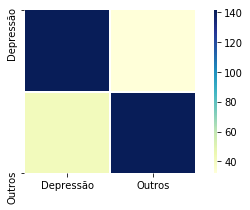

In [17]:
vectorizer = CountVectorizer()

print("=== SVM - TF-IDF com GridSearch ===\n")

train_data_tfidf = vectorizer.fit_transform(X_train)
test_data_tfidf = vectorizer.transform(X_test)

clf_tfidf = gs_result(train_data_tfidf, Y_train, test_data_tfidf, Y_test)

with open("svm_tfidf.pickle", "wb") as f:
    pickle.dump(clf_tfidf, f)

with open("vectorizer.pickle", "wb") as f:
    pickle.dump(vectorizer, f)

=== SVM - Word2Vec com GridSearch ===

Melhores parâmetros: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Melhor score: 0.80%

Acurácia : 0.75%
Precisão : 0.76%
Revocação : 0.75%
F1 : 0.76%



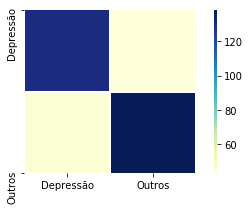

In [18]:
print("=== SVM - Word2Vec com GridSearch ===\n")

train_data_w2v = list(X_train.apply(avg_feat_vector))
test_data_w2v = list(X_test.apply(avg_feat_vector))

clf_w2v  = gs_result(train_data_w2v, Y_train, test_data_w2v, Y_test)

with open("svm_w2v.pickle", "wb") as f:
    pickle.dump(clf_w2v, f)

with open("model_w2v.pickle", "wb") as f:
    pickle.dump(model, f)

In [35]:
sentece = "Quero muito morrer mesmo"
sentece = clean_text(sentece)

prob_tfidf = clf_tfidf.predict_proba(vectorizer.transform([sentece]).todense())
prob_w2v = clf_w2v.best_estimator_.predict_proba([list(avg_feat_vector(sentece))])

In [36]:
print(prob_tfidf, prob_w2v)

[[0.8294044 0.1705956]] [[0.42558949 0.57441051]]


In [37]:
sentece = "To cansado, quero viver bem"
sentece = clean_text(sentece)

prob_tfidf = clf_tfidf.predict_proba(vectorizer.transform([sentece]).todense())
prob_w2v = clf_w2v.best_estimator_.predict_proba([list(avg_feat_vector(sentece))])

In [38]:
print(prob_tfidf, prob_w2v)

[[0.0601271 0.9398729]] [[0.55599411 0.44400589]]
